In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import dic
import math as m
import math
%matplotlib inline

#RANSAC/SKIMAGE packages
from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.transform import warp, AffineTransform, PolynomialTransform, ProjectiveTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac
import copy
from numpy import loadtxt
import numpy.linalg as la
from scipy.interpolate import griddata

In [2]:
#load image set from directory
image_set = dic.LoadImages()
#load settings from text file
settings = dic.LoadSettings(image_set)
#no of images in directory
N_images = len(image_set) 
#replace this with pandas entry
print('\nImage set:', image_set)
print('\nSettings:', settings)


Image set: ['R50.tif', 'L1000.tif', 'R1000.tif', 'L100.tif', 'L125.tif', 'L50.tif', 'L10.tif', 'R125.tif', 'L950.tif', 'L1.tif', 'R0.tif', 'L0.tif', 'R950.tif', 'R100.tif', 'R1.tif', 'R10.tif']

Settings: {'SubsetSize': 31, 'ShapeFunctionOrder': 1, 'GaussianFilterStdDev': 0.5, 'GaussianFilterSize': 5, 'CorrelationReferenceStrategy': 'Incremental', 'SubsetFrequency': 20, 'ImageColumns': 2448, 'ImageRows': 2048, 'Calibration': 'No', 'SubsetShape': 'Square'}


In [3]:
#initialise reference image objects from both cameras for subset matching
#load reference image of first camera
F1 = dic.ReferenceImage(cv.imread('images2/L0.tif', 0), settings)

# #specify ROI in reference image
# cv.namedWindow('Select ROI', cv.WINDOW_NORMAL)
# ROI = cv.selectROI('Select ROI', F1.image, showCrosshair=  True)
# cv.destroyAllWindows()

# #store ROI intensity values as array
# F1_ROI = F1.image_8bit[int(ROI[1]):int(ROI[1]+ROI[3]),
#                   int(ROI[0]):int(ROI[0]+ROI[2])]

F1_ROI = F1.image_8bit[int(690):int(1381),
                   int(50):int(2300)]

ROI =  (50, 690, 2300-50, 1381-690)

#create subsets and initialise SFPs
F1.CreateSubsets(settings, ROI)

#deformed image object
F2 = dic.ReferenceImage(cv.imread('images2/R0.tif', 0), settings)
F2.CreateSubsets(settings, ROI)

print('\n ROI bounds:')
print('y', int(ROI[1]), int(ROI[1]+ROI[3]))
print('x', int(ROI[0]), int(ROI[0]+ROI[2]))

print('\nF1 subset centre coordinates')
print(F1.sub_centers[:, 0:5])
print('\nF2 subset centre coordinates, before matching')
print(F2.sub_centers[:, 0:5])

print('\nF1 image bounds', F1.image.shape)


 ROI bounds:
y 690 1381
x 50 2300

F1 subset centre coordinates
[[220 220 220 220 220]
 [860 880 900 920 940]]

F2 subset centre coordinates, before matching
[[220 220 220 220 220]
 [860 880 900 920 940]]

F1 image bounds (2048, 2448)


In [4]:
#create padded image for ROI, keypoint matching

F1_ROI_padded = np.zeros([F1.image.shape[0], F1.image.shape[1]])
F1_ROI_padded[int(ROI[1]):int(ROI[1]+ROI[3]),
              int(ROI[0]):int(ROI[0]+ROI[2])] = F1_ROI
F1_ROI_padded = F1_ROI_padded.astype(np.uint8)

[ WARN:0@5.590] global /opt/conda/conda-bld/opencv-suite_1664548337286/work/opencv_contrib-4.6.0/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


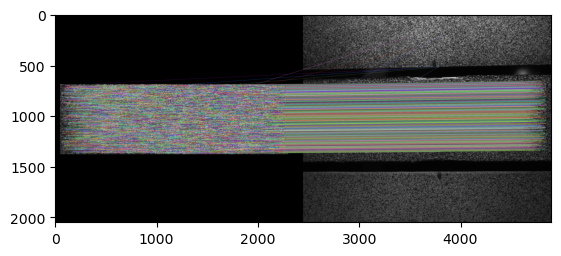

In [5]:
#perform keypoint matching between two camera views for specified ROI
Xk1, Xk2, Xo1, N_subsets, kp1, kp2, d1, d2 = dic.SIFTquick(F1_ROI_padded, F1,  F2)
Xk1, Xk2 = dic.KeypointMatchRobust(Xk1, Xk2, kp1, kp2, d1, d2, F1_ROI_padded, F2)

In [6]:
#identify K nearest keypoints to each subset centre
kNN_indices = dic.kNNSubCentres(N_subsets, Xo1, Xk1, k = 10)
#find subset centre coordinates in image 2 using the projective transformation
F2_sub_centers = dic.MatchSubCentresProjective(F1, F2, N_subsets, Xk1, Xk2, kNN_indices)

In [7]:
#assign F2 subset subset centers

print('\nF1 subset centre coordinates')
print(F1.sub_centers[:, 0:10])
print('\nF2 subset centre coordinates, before matching')
print(F2.sub_centers[:, 0:10])
F2.sub_centers = F2_sub_centers
print('\nF2 subset centre coordinates, after matching')
print(F2.sub_centers[:, 0:10])


F1 subset centre coordinates
[[ 220  220  220  220  220  220  220  220  220  220]
 [ 860  880  900  920  940  960  980 1000 1020 1040]]

F2 subset centre coordinates, before matching
[[ 316  316  316  317  318  318  318  319  319  320]
 [ 864  883  903  922  941  960  979  998 1017 1036]]

F2 subset centre coordinates, after matching
[[ 316  316  316  317  318  318  318  319  319  320]
 [ 864  883  903  922  941  960  979  998 1017 1036]]


In [8]:
#identify subsets in F2 that have coordinates exceeding the image bounds

print('\nF1 image bounds\n', F2.image.shape)
print('Coordinate bounds in F2')
print(np.max(F1.sub_centers[1, :]), np.max(F1.sub_centers[0, :]))
print(np.max(F2_sub_centers[1, :]), np.max(F2_sub_centers[0, :]))
print('coordinates exceed x bounds:', np.where(F2.sub_centers[0, :] > F1.img_columns)[0].shape[0])
print('coordinates exceed y bounds:', np.where(F2.sub_centers[1, :] > F1.img_rows)[0].shape[0])
print(F1.sub_centers.shape)
invalid_x_indices = np.where(F2.sub_centers[0, :] > F1.img_columns)[0]
print('Invalid subsets in ROI:\n', invalid_x_indices.shape[0], '\nfraction of total no. subsets:\n', 100*invalid_x_indices.shape[0]/F1.sub_centers.shape[1], 'percent')
invalid_y_indices = np.where(F2.sub_centers[1, :] > F1.img_rows)[0]

print(invalid_x_indices)

invalid_sub_indices = np.array([])
if invalid_x_indices.shape[0] == 0:
    print('No invalid x indices')
else:
    invalid_sub_indices = np.append(invalid_sub_indices, invalid_x_indices)
if invalid_y_indices.shape[0] == 0:
    print('No invalid y indices')
else:
    invalid_sub_indices = np.append(invalid_sub_indices, invalid_y_indices)



F1 image bounds
 (2048, 2448)
Coordinate bounds in F2
1220 2140
1208 2248
coordinates exceed x bounds: 0
coordinates exceed y bounds: 0
(2, 1843)
Invalid subsets in ROI:
 0 
fraction of total no. subsets:
 0.0 percent
[]
No invalid x indices
No invalid y indices


In [9]:
################################################################
#CORRELATION
    #perform 2D_subset_based correlation between F1 and F2, find P_converg
#compute F2 subset centre positions using P_converg and F1_Xo

In [10]:
#Right camera, perform 2D_subset based correlation

R0 = copy.deepcopy(F2)
R1 = dic.DeformedImage(cv.imread('images2/R10.tif', 0), settings)
R1.InitCorrelationParams(R0)

#initialise subset centre positions, reference and deformed images
#check SF order:
#1st order SF
if settings['ShapeFunctionOrder'] == 1:
    R1.sub_centers[0,:] = R0.sub_centers[0,:] + np.round(R0.P[0,:])
    R1.sub_centers[1,:] = R0.sub_centers[1,:] + np.round(R0.P[3,:])

    #initial estimate of the shape function as rigid body translation
    R1.P[0,:], R1.P[3,:] = dic.EstimateDisplacementsFourier(R0, R1, invalid_sub_indices)

#2nd order SF
else:
    R1.sub_centers[0,:] = R0.sub_centers[0,:] + np.round(R0.P[0,:])
    R1.sub_centers[1,:] = R0.sub_centers[1,:] + np.round(R0.P[6,:])

    #initial estimate of the shape function as rigid body translation
    R1.P[0,:], R1.P[6,:] = dic.EstimateDisplacementsFourier(R0, R1, invalid_sub_indices)

#perform correlation
dic.CorrelateImages2D(R0, R1, settings, invalid_sub_indices)


/home/ed/Documents/code/dic/development/dic.py:699: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w_dP = np.array([


In [11]:
# print('Extremes of correlation ', np.min(R1.corr_coeff), np.max(R1.corr_coeff))


# for i in range(0, invalid_sub_indices.shape[0]):
#     j = int(invalid_sub_indices[i])
#     R1.P[:,j:j+1] = np.nan*np.ones([6, 1])

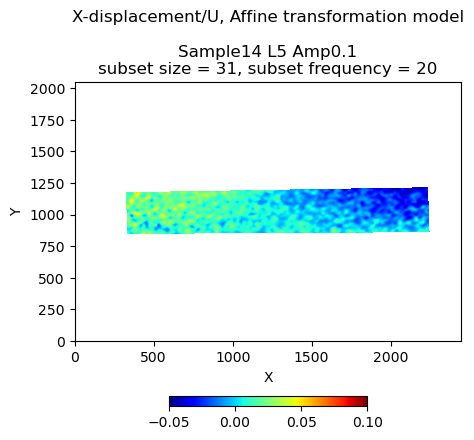

Limits:
 -0.05426063349166841 
 0.0559381873521769


In [12]:
##plot x-displacement results
u = R1.P[0, :]
N_subsets = R1.P.shape[1]
N_rows = R1.image.shape[0]
N_cols = R1.image.shape[1]
yo = R1.sub_centers[1, :]
xo = R1.sub_centers[0, :]
#
XY = np.zeros([N_subsets, 2])
for i in range(0, N_subsets):
    XY[i, :] = (yo[i], xo[i])
grid_x, grid_y = np.mgrid[0:N_cols:1, 0:N_rows:1]
U_new_grid = griddata(XY, u, (grid_y, grid_x), method='cubic')
U_new_grid = U_new_grid.T
#
plt.imshow(U_new_grid, extent=(0,N_cols ,0, N_rows),cmap = 'jet', aspect = '0.8')
plt.colorbar(location = 'bottom', shrink = 0.4)
plt.clim(-0.05, 0.1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X-displacement/U, Affine transformation model\n\nSample14 L5 Amp0.1\nsubset size = {}, subset frequency = {}'.format(R1.sub_size, R1.frequency))
plt.show()

print('Limits:\n', np.min(u), '\n', np.max(u))

In [13]:
#Left camera, perform 2D_subset based correlation

#load reference image of first camera
L0 = dic.ReferenceImage(cv.imread('images2/L0.tif', 0), settings)
L0.CreateSubsets(settings, ROI)
#displace subset centre coordinates with displacement results from stereomatching

#load first deformed image from left camera series
L1 = dic.DeformedImage(cv.imread('images2/L10.tif', 0), settings)
L1.InitCorrelationParams(L0)

#initialise subset centre positions, reference and deformed images
#check SF order:
#1st order SF
if settings['ShapeFunctionOrder'] == 1:
    L1.sub_centers[0,:] = L0.sub_centers[0,:] + np.round(L0.P[0,:])
    L1.sub_centers[1,:] = L0.sub_centers[1,:] + np.round(L0.P[3,:])

    #initial estimate of the shape function as rigid body translation
    L1.P[0,:], L1.P[3,:] = dic.EstimateDisplacementsFourier(L0, L1, invalid_sub_indices)

#2nd order SF
else:
    L1.sub_centers[0,:] = L0.sub_centers[0,:] + np.round(L0.P[0,:])
    L1.sub_centers[1,:] = L0.sub_centers[1,:] + np.round(L0.P[6,:])

    #initial estimate of the shape function as rigid body translation
    L1.P[0,:], L1.P[6,:] = dic.EstimateDisplacementsFourier(L0, L1, invalid_sub_indices)

#perform correlation
dic.CorrelateImages2D(L0, L1, settings, invalid_sub_indices)

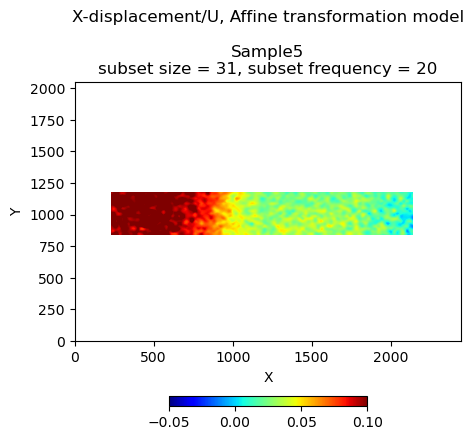

Limits:
 -0.015421161050309893 
 0.12753132586561325


In [14]:
#plot x-displacement results
u = L1.P[0, :]
N_subsets = L1.P.shape[1]
N_rows = L1.image.shape[0]
N_cols = L1.image.shape[1]
yo = L1.sub_centers[1, :]
xo = L1.sub_centers[0, :]
#
XY = np.zeros([N_subsets, 2])
for i in range(0, N_subsets):
    XY[i, :] = (yo[i], xo[i])
grid_x, grid_y = np.mgrid[0:N_cols:1, 0:N_rows:1]
U_new_grid = griddata(XY, u, (grid_y, grid_x), method='cubic')
U_new_grid = U_new_grid.T
#
plt.imshow(U_new_grid, extent=(0,N_cols ,0, N_rows),cmap = 'jet', aspect = '0.8')

plt.colorbar(location = 'bottom', shrink = 0.4)
plt.clim(-0.05, 0.1)
plt.xlabel('X')
plt.ylabel('Y')

plt.title('X-displacement/U, Affine transformation model\n\nSample5\nsubset size = {}, subset frequency = {}'.format(L1.sub_size, L1.frequency))
plt.show()

print('Limits:\n', np.min(u), '\n', np.max(u))

In [15]:
#TRIANGULATION OF RESULTS

In [16]:
Q1 = open('Q1_mat.csv', 'rb')
Q1 = loadtxt(Q1, delimiter = ",")
Q1 = np.array(Q1)

Q2 = open('Q2_mat.csv', 'rb')
Q2 = loadtxt(Q2, delimiter = ",")
Q2 = np.array(Q2)

Fu = open('B_mat.csv', 'rb')
Fu = loadtxt(Fu, delimiter = ",")
Fu = np.array(Fu)

K1 = open('K1_mat.csv', 'rb')
K1 = loadtxt(K1, delimiter = ",")
K1 = np.array(K1)

K2 = open('K2_mat.csv', 'rb')
K2 = loadtxt(K2, delimiter = ",")
K2 = np.array(K2)

r1 = open('r1_mat.csv', 'rb')
r1 = loadtxt(r1, delimiter = ",")
r1 = np.array(r1)

r2 = open('r2_mat.csv', 'rb')
r2 = loadtxt(r2, delimiter = ",")
r2 = np.array(r2)

print('Q1:\n', Q1)
print('\nQ2:\n', Q2)
print('\nB:\n', Fu)
print('\nr1:\n', r1)
print('\nr2:\n', r2)
print('\nK1:\n', K1)
print('\nK2:\n', K2)


Q1:
 [[1.2629e+04 0.0000e+00 1.3201e+03 0.0000e+00]
 [0.0000e+00 1.2604e+04 1.0323e+03 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]]

Q2:
 [[ 1.0524e+04  1.5927e+02  7.0177e+03 -1.0672e+06]
 [-6.4662e+02  1.2548e+04  8.6989e+02  2.7692e+04]
 [-4.6533e-01 -6.5656e-03  8.8511e-01  2.2162e+01]]

B:
 [[ 7.2400e-10 -1.3975e-07  1.7642e-04]
 [-1.3198e-07 -1.7460e-09  7.1392e-03]
 [ 1.9978e-04 -6.7272e-03 -4.2536e-01]]

r1:
 [  0.15688 -11.852     0.        0.        0.     ]

r2:
 [  0.1793 -12.634    0.       0.       0.    ]

K1:
 [[1.2629e+04 0.0000e+00 1.3201e+03]
 [0.0000e+00 1.2604e+04 1.0323e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]

K2:
 [[1.2582e+04 0.0000e+00 1.3130e+03]
 [0.0000e+00 1.2556e+04 9.8845e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [17]:
#subset centre positions in reference image
Xo1 = np.vstack((np.array([L0.sub_centers[0, :]]), np.array([L0.sub_centers[1, :]]))).astype('double')
Xo2 = np.vstack((np.array([R0.sub_centers[0, :]]), np.array([R0.sub_centers[1, :]]))).astype('double')
#displacement of subset centres after correlation convergence
P1 = np.vstack((np.array([L1.P[0, :]]), np.array([L1.P[3, :]]))).astype('double')
P2 = np.vstack((np.array([R1.P[0, :]]), np.array([R1.P[3, :]]))).astype('double')
#perform only on the deformed images of the image series for now
#displaced subset centre positions in deformed image
Xod1 = Xo1 + P1
Xod2 = Xo2 + P2

print(Xo1[:, 0:5])
print(Xod1[:, 0:5].astype('double'))

print(Xo2[:, 0:5])
print(Xod2[:, 0:5].astype('double'))


[[220. 220. 220. 220. 220.]
 [860. 880. 900. 920. 940.]]
[[220.10242184 220.09591807 220.10200632 220.10475392 220.10195124]
 [859.98249275 879.9700332  899.97583765 919.97389883 939.96746642]]
[[316. 316. 316. 317. 318.]
 [864. 883. 903. 922. 941.]]
[[316.02571902 316.0309219  316.02212348 317.02337943 318.01327324]
 [863.94610153 882.96227939 902.95170514 921.96393619 940.97171986]]


In [18]:
Xow = dic.Triangulate(Fu, Q1, Q2, dic.UndistortPoints(Xo1.T, K1, r1).T, dic.UndistortPoints(Xo2.T, K2, r2).T, invalid_sub_indices)
#Xow = dic.Triangulate(Fu, Q2, Q1, dic.UndistortPoints(Xo2.T, K2, r2).T, dic.UndistortPoints(Xo1.T, K1, r1).T, invalid_sub_indices)

In [19]:
Xdw = dic.Triangulate(Fu, Q1, Q2, dic.UndistortPoints(Xod1.T, K1, r1).T, dic.UndistortPoints(Xod2.T, K2, r2).T, invalid_sub_indices)
#Xdw = dic.Triangulate(Fu, Q2, Q1, dic.UndistortPoints(Xod2.T, K2, r2).T, dic.UndistortPoints(Xod1.T, K1, r1).T, invalid_sub_indices)

Uw.shape (3, 1843)


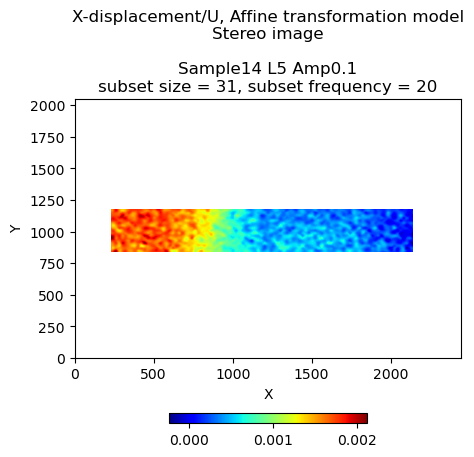

Limits:
 -0.0002053113780160487 
 0.002087427574588574


In [32]:
#displacement in world coordinates
Uw = Xdw - Xow
print('Uw.shape', Uw.shape)
#plot x-displacement results
u = Uw[0, :]
N_subsets = L1.P.shape[1]
N_rows = L1.image.shape[0]
N_cols = L1.image.shape[1]
yo = L1.sub_centers[1, :]
xo = L1.sub_centers[0, :]
#
XY = np.zeros([N_subsets, 2])
for i in range(0, N_subsets):
    XY[i, :] = (yo[i], xo[i])
grid_x, grid_y = np.mgrid[0:N_cols:1, 0:N_rows:1]
U_new_grid = griddata(XY, u, (grid_y, grid_x), method='cubic')
U_new_grid = U_new_grid.T
#
plt.imshow(U_new_grid, extent=(0,N_cols ,0, N_rows),cmap = 'jet', aspect = '0.8')
plt.colorbar(location = 'bottom', shrink = 0.4)
#plt.clim(-0.05, 0.1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X-displacement/U, Affine transformation model\nStereo image\n\nSample14 L5 Amp0.1\nsubset size = {}, subset frequency = {}'.format(L1.sub_size, L1.frequency))
plt.show()

print('Limits:\n', np.min(u), '\n', np.max(u))



In [21]:
u = open('Uw.csv', 'rb')
u = loadtxt(u, delimiter = ",")
u = np.array(u)
v = open('Vw.csv', 'rb')
v = loadtxt(v, delimiter = ",")
v = np.array(v)
w = open('Ww.csv', 'rb')
w = loadtxt(w, delimiter = ",")
w = np.array(w)
##

print(L0.sub_centers[:, 0:10])


print(100*abs(Uw[0, 0:10]-u)/abs(Uw[0, 0:10]))

print(100*abs(Uw[1, 0:10]-v)/abs(Uw[1, 0:10]))

print(100*abs(Uw[2, 0:10]-w)/abs(Uw[2, 0:10]))

[[ 220  220  220  220  220  220  220  220  220  220]
 [ 860  880  900  920  940  960  980 1000 1020 1040]]
[54.52639039 47.76282118 52.78610666 54.554726   63.83802819 67.36866901
 57.38433695 56.66161925 70.9855593  70.39300587]
[  81.93912208  165.19213242  185.74566796  164.34129367  168.85605518
  349.69543041 1591.38341636  557.55872692  134.34316754  181.62257017]
[59.05324209 26.22135187 34.65494032 57.85591618 83.53021556 82.49639467
 52.9252725  41.45921492 87.70544452 93.38219309]


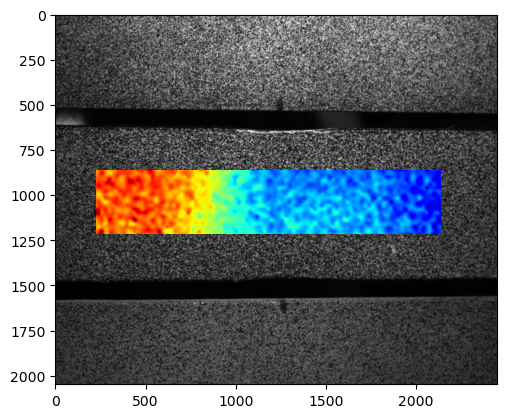

In [22]:
plt.imshow(F1.image, cmap = 'gray')
plt.imshow(U_new_grid, cmap = 'jet')
plt.show()

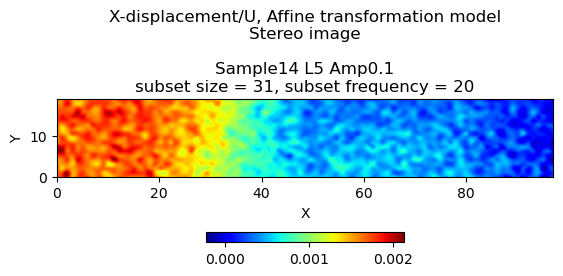

In [23]:
N_cols = np.unique(L0.sub_centers[0, :]).shape[0]
N_rows = np.unique(L0.sub_centers[1, :]).shape[0]
freq = L1.frequency

#plot x-displacement results
u = Uw[0, :]
N_subsets = L1.P.shape[1]
yo = L1.sub_centers[1, :]
xo = L1.sub_centers[0, :]
#
XY = np.zeros([N_subsets, 2])
for i in range(0, N_subsets):
    XY[i, :] = (yo[i], xo[i])
grid_x, grid_y = np.mgrid[xo[0]:xo[-1:][0]:1, yo[0]:yo[-1:][0]:1]
U_new_grid = griddata(XY, u, (grid_y, grid_x), method='cubic')
U_new_grid = U_new_grid.T
#
plt.imshow(U_new_grid, extent=(0,N_cols ,0, N_rows),cmap = 'jet', aspect = '0.8')
plt.colorbar(location = 'bottom', shrink = 0.4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X-displacement/U, Affine transformation model\nStereo image\n\nSample14 L5 Amp0.1\nsubset size = {}, subset frequency = {}'.format(L1.sub_size, L1.frequency))
plt.show()

#grid_x, grid_y = np.mgrid[0:N_cols:1, 0:N_rows:1]

In [24]:
N_cols = np.unique(L0.sub_centers[0, :]).shape[0]
N_rows = np.unique(L0.sub_centers[1, :]).shape[0]
print('ROI dimensions',N_rows, N_cols)
print(xo[0])
print(yo[0])
print(N_cols)
print(N_rows)
print()
print(yo[0])
print(xo)

ROI dimensions 19 97
220
860
97
19

860
[ 220  220  220 ... 2140 2140 2140]


In [25]:
#load calibration results:
#camera intrinsic parameters (camera matrix)

from numpy import loadtxt

camera_matrix = open('camera_matrix.csv', 'rb')
camera_matrix = loadtxt(camera_matrix ,delimiter = ",")
camera_matrix = np.array(camera_matrix)

dist_coeff = open('distortion_coefficient.csv', 'rb')
dist_coeff = loadtxt(dist_coeff ,delimiter = ",")
dist_coeff = np.array(dist_coeff)

print('Camera matrix:\n', camera_matrix,'\n')
print('distortion coefficients:\n', dist_coeff)

Camera matrix:
 [[4.78454124e+03 0.00000000e+00 1.27509167e+03]
 [0.00000000e+00 4.78619778e+03 1.06960325e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

distortion coefficients:
 [-2.50645500e-01  1.02728031e+00 -9.37219752e-04  1.32911119e-04
 -9.08042444e+00]


In [26]:
print(L0.sub_centers[:,0:20])
print(L1.P[0,0:20])
print(L1.P[1,0:20])

[[ 220  220  220  220  220  220  220  220  220  220  220  220  220  220
   220  220  220  220  220  240]
 [ 860  880  900  920  940  960  980 1000 1020 1040 1060 1080 1100 1120
  1140 1160 1180 1200 1220  860]]
[0.10242184 0.09591807 0.10200632 0.10475392 0.10195124 0.10845802
 0.102719   0.10556809 0.09995033 0.08782236 0.09363924 0.11658717
 0.12114277 0.10377848 0.09267312 0.09267429 0.10136426 0.10503186
 0.10326325 0.09652959]
[-8.38221590e-04  1.19732622e-03  6.31952885e-04  1.78699850e-04
  1.18797101e-03  4.95850287e-04 -1.84643935e-03 -2.35582311e-03
 -2.02137292e-03  6.25329110e-04  2.09706168e-04  6.90698882e-04
  1.71993445e-03 -6.21965647e-04 -1.11788335e-03 -1.55588054e-05
 -3.80780935e-04 -1.55276336e-03 -4.09472822e-04 -1.84827426e-04]


In [27]:
E = open('Essential_MATLAB.csv', 'rb')
E = loadtxt(E ,delimiter = ",")
E = np.array(E)
print('Essential matrix:\n', E)

test = cv.decomposeEssentialMat(E)

print('\nRotation matrix:\n',test[0])
#print('\n',test[1])
print('\nTranslation:\n',test[2])

R, t = test[0], test[2]

Essential matrix:
 [[  0.11505 -22.163     0.41668]
 [-20.929    -0.27632  87.431  ]
 [  0.88745 -87.124    -0.17971]]

Rotation matrix:
 [[ 8.85011843e-01  1.33437082e-02  4.65377248e-01]
 [-1.48661801e-02  9.99889413e-01 -3.98573565e-04]
 [-4.65331102e-01 -6.56563967e-03  8.85112342e-01]]

Translation:
 [[ 0.96912559]
 [-0.00512538]
 [-0.24651433]]


In [28]:
E = open('Essential_MATLAB.csv', 'rb')
E = loadtxt(E ,delimiter = ",")
E = np.array(E)
E = E.T
print('Essential matrix: (transpose of MATLAB version)\n', E)

test = cv.decomposeEssentialMat(E)
print('\nRotation matrix\n(camera 2 relative to camera 1)\n',test[1])
print('\nTranslation matrix\n(camera 2 relative to camera 1)\n',test[2])

U, S, V = la.svd(E)
print('\nSingular value matrix:\n', S)

print('\nScaled translation matrix:\n', S[0]*test[2])

Essential matrix: (transpose of MATLAB version)
 [[  0.11505 -20.929     0.88745]
 [-22.163    -0.27632 -87.124  ]
 [  0.41668  87.431    -0.17971]]

Rotation matrix
(camera 2 relative to camera 1)
 [[ 8.85011843e-01 -1.48661801e-02 -4.65331102e-01]
 [ 1.33437082e-02  9.99889413e-01 -6.56563967e-03]
 [ 4.65377248e-01 -3.98573565e-04  8.85112342e-01]]

Translation matrix
(camera 2 relative to camera 1)
 [[0.97247461]
 [0.00942544]
 [0.23281817]]

Singular value matrix:
 [8.99031943e+01 8.99026778e+01 2.27917512e-06]

Scaled translation matrix:
 [[87.42857351]
 [ 0.84737741]
 [20.93109725]]


In [29]:
#pseudocode:
    #STEREOMATCHING 
        #load images 
        #define ROI in target image
            #subset selection tool
        #create subsets inside ROI of target image
            #change CreateSubsets method to be customisable
        #keypoint matching over entire image
            #define F1
            #refine F1 ROI
            #find keypoints and descriptors in F1_ROI
            #find keypoints and descriptors in F2
            #match keypoints between F1 and F2
        #initial SFP's of homography between F1 and F2    
            #find kNN in F1
            #perform RANSAC on kNN keypoint matches between F1 and F2, find P0
        ## SKIP FOR NOW ##
        #stereomatching correlation
            #perform 2D_subset_based correlation between F1 and F2, find P_stereo at converg
        #compute F2 subset centre positions using P_converg and F1_Xo
        ##

    #SUBSET CORRELATION
        #correlate first image set
        #correlate second image set
            #(subset centres postions based on stereomatch SFPs results)

    #COORDINATE SYSTEM TRANSFORMATION
        #
